In [ ]:
!pip install datasets
from datasets import load_dataset
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

from collections import Counter, defaultdict

## Задание 1. Найти или сгенерировать набор данных для бинарной классификации графов.

In [2]:
data = load_dataset("graphs-datasets/AIDS");
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

(…)-00000-of-00001-2a1e5fb28f54a227.parquet:   0%|          | 0.00/166k [00:00<?, ?B/s]

Generating full split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    full: Dataset({
        features: ['edge_index', 'node_feat', 'edge_attr', 'y', 'num_nodes'],
        num_rows: 2000
    })
})

In [3]:
graphs = data['full']
train_indices, test_indices = train_test_split(list(range(len(graphs))), test_size=0.2, random_state=21, stratify=graphs['y'])

train_dataset = graphs.select(train_indices)
test_dataset = graphs.select(test_indices)

Из описания с huggingface https://huggingface.co/datasets/graphs-datasets/AIDS: \
The AIDS dataset is a dataset containing compounds checked for evidence of anti-HIV activity..

## Функция отрисовки графа

In [4]:
def vis_graph(graph_data):
    edge_index = graph_data['edge_index']
    num_nodes = graph_data['num_nodes']
    node_labels = [str(int(label[0])) if isinstance(label, list) else str(label) for label in graph_data['node_feat']]

    G = nx.Graph()

    for i in range(num_nodes):
        G.add_node(i, label=str(node_labels[i]))

    edges = list(zip(edge_index[0], edge_index[1]))
    G.add_edges_from(edges)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    labels = nx.get_node_attributes(G, 'label')

    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_edges(G, pos, width=1.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=12)

    plt.axis('off')
    plt.show()

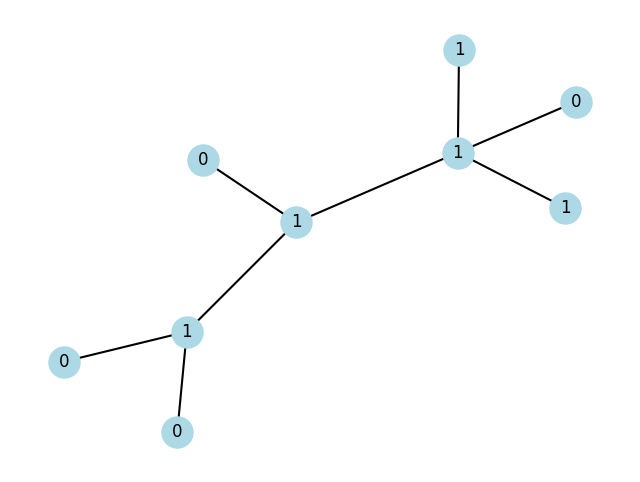

In [5]:
vis_graph(random.sample(list(train_dataset), 1)[0])

## Задание 2. Реализовать функцию shortest_path_kernel

## Перевод графа в вектор с числом кратчайших путей определенной длины

In [6]:
def shortest_path_vector(G, max_length):
    path_lengths = dict(nx.shortest_path_length(G))
    path_length_counts = {}
    for source in path_lengths:
        for target, length in path_lengths[source].items():
            if source != target:
                if length not in path_length_counts:
                    path_length_counts[length] = 0
                path_length_counts[length] += 1
    vector = np.zeros(max_length + 1)
    for length, count in path_length_counts.items():
        if length <= max_length:
            vector[length] = count
    return vector

In [7]:
def shortest_path_kernel(train_graphs, test_graphs):
    max_train_length = max([max([max(lengths.values()) for lengths in dict(nx.shortest_path_length(G)).values()]) for G in train_graphs])
    max_test_length = max([max([max(lengths.values()) for lengths in dict(nx.shortest_path_length(G)).values()]) for G in test_graphs])

    max_length = max(max_train_length, max_test_length)

    train_vectors = [shortest_path_vector(G, max_length) for G in train_graphs]
    test_vectors = [shortest_path_vector(G, max_length) for G in test_graphs]

    n_train = len(train_vectors)
    K_train = np.zeros((n_train, n_train))

    for i in range(n_train):
        for j in range(n_train):
            K_train[i, j] = np.dot(train_vectors[i], train_vectors[j])

    n_test = len(test_vectors)
    K_test = np.zeros((n_test, n_train))

    for i in range(n_test):
        for j in range(n_train):
            K_test[i, j] = np.dot(test_vectors[i], train_vectors[j])

    return K_train, K_test

In [8]:
def convert_dataset(dataset):
    graphs = []
    for item in dataset:
        G = nx.Graph()
        num_nodes, edge_index = item['num_nodes'], item['edge_index']
        for node_id in range(num_nodes):
            G.add_node(node_id)
        edges = list(zip(edge_index[0], edge_index[1]))
        G.add_edges_from(edges)
        graphs.append(G)
    return graphs

In [9]:
train_graphs = convert_dataset(train_dataset)
test_graphs = convert_dataset(test_dataset)

train_labels = train_dataset['y']
test_labels = test_dataset['y']

## Задание 3. Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества

In [10]:
param_grid = {'C': [0.1, 1, 10., 1000.]}
K_train, K_test = shortest_path_kernel(train_graphs, test_graphs)
train_labels = np.ravel(train_labels)
test_labels = np.ravel(test_labels)

svc = SVC(kernel="precomputed", verbose = False, max_iter = 1000000)
clf = GridSearchCV(svc, param_grid, cv=5)
clf.fit(K_train, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=5, estimator=SVC(kernel='precomputed', max_iter=1000000),
             param_grid={'C': [0.1, 1, 10.0, 1000.0]})

In [11]:
y_pred = clf.predict(K_test)

accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"accuracy: {accuracy:.3f}")
print(f"recall: {recall:.3f}")
print(f"f1: {f1:.3f}")
print(f"precision: {precision:.3f}")

accuracy: 0.998
recall: 1.000
f1: 0.998
precision: 0.997


## Задание 4. Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [12]:
def generate_node_labels(graph):
    labels = {}
    for node in graph.nodes():
        labels[node] = str(node)
    return labels

def relabel_graph(graph, labels):
    new_labels = defaultdict(list)
    for node in graph.nodes():
        neighborhood = [labels[neighbor] for neighbor in graph.neighbors(node)]
        neighborhood.append(labels[node])
        new_labels[node] = ''.join(sorted(neighborhood))
    return new_labels

def compute_wl_features(graph, h):
    labels = generate_node_labels(graph)
    wl_features = [list(labels.values())]
    for i in range(h):
        labels = relabel_graph(graph, labels)
        wl_features.append(list(labels.values()))
    return wl_features

def feature_vector(wl_features, all_labels):
    counter = defaultdict(int)
    for iteration_labels in wl_features:
        for label in iteration_labels:
            counter[label] += 1
    return np.array([counter[label] for label in all_labels])

def collect_all_labels(graphs, h):
    all_labels = set()
    for g in graphs:
        wl_features = compute_wl_features(g, h)
        for iteration_labels in wl_features:
            all_labels.update(iteration_labels)
    return sorted(all_labels)

def compute_kernel_matrix(graphs1, graphs2, h, all_labels):
    n1 = len(graphs1)
    n2 = len(graphs2)
    K = np.zeros((n1, n2))

    for i, g1 in enumerate(graphs1):
        g1_features = feature_vector(compute_wl_features(g1, h), all_labels)
        for j, g2 in enumerate(graphs2):
            g2_features = feature_vector(compute_wl_features(g2, h), all_labels)
            K[i, j] = np.dot(g1_features, g2_features)

    return K

def wl_kernel(train_graphs, test_graphs, h=2):
    all_labels = collect_all_labels(train_graphs + test_graphs, h)
    K_train = compute_kernel_matrix(train_graphs, train_graphs, h, all_labels)
    K_test = compute_kernel_matrix(test_graphs, train_graphs, h, all_labels)
    return K_train, K_test

In [13]:
K_train, K_test = wl_kernel(train_graphs[:400], test_graphs[:100])
train_labels = np.ravel(train_labels[:400])
test_labels = np.ravel(test_labels[:100])

In [14]:
param_grid = {'C': [0.1, 1, 10.]}
svc = SVC(kernel="precomputed")
clf = GridSearchCV(svc, param_grid, cv=5)
clf.fit(K_train, train_labels)

GridSearchCV(cv=5, estimator=SVC(kernel='precomputed'),
             param_grid={'C': [0.1, 1, 10.0]})

In [15]:
y_pred = clf.predict(K_test)

accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"accuracy: {accuracy:.3f}")
print(f"recall: {recall:.3f}")
print(f"f1: {f1:.3f}")
print(f"precision: {precision:.3f}")

accuracy: 1.000
recall: 1.000
f1: 1.000
precision: 1.000


**Вывод:**
Оба метода показывают высокие метрики на данном датасете, однако подсчет Weisfeiler-Lehman Kernel достаточно долгий, и пришлось обрезать выборку до 1000 трейна и 300 теста, но метрики там оказались тоже ок